# Covid-19 Prediction

by [Mohammad Toutiaee]

## Introduction

This code tries to predict the future Covid-19 cases of Georgia using Covid-data from several other States.

Because we will be working with sequences of arbitrary length, we will use a Recurrent Neural Network (RNN).

## Location

We will use Covid-data from the period March - Present 2020 for five States in the U.S.

* Florida
* North Carolina
* South Carolina
* Alabama
* Georgia

The following map shows the location of the States in the U.S.:

![Map of Denmark](https://map1.maploco.com/visited-states/ml/AL-FL-GA-NC-SC.png)

## Flowchart

In this code, we are trying to predict the Covid-19 for Georgia 7 days into the future, given the current and past Covid-data from 5 States.

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import io
import requests
from sklearn.preprocessing import MinMaxScaler, scale, StandardScaler

We need to import several things from Keras.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

These are the top rows of the data-set.

In [ ]:
url="https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
s=requests.get(url).content
have=pd.read_csv(io.StringIO(s.decode('utf-8')))

In [ ]:
df = pd.DataFrame(data=have)
df.drop('fips',
  axis='columns', inplace=True)

df.drop('county',
  axis='columns', inplace=True)

df = df[["date", "state", "cases","deaths"]]

is_state =  (df['state']=='Georgia') | (df['state']=='Alabama') | (df['state']=='Florida') | (df['state']=='North Carolina') | (df['state']=='South Carolina')
d0 = df[is_state]
d1 = d0[(d0['date'] > '2020-03-12')]
d2 = d1.set_index(['date', 'state'])
d3 = d2.groupby(['date','state']).agg({'cases': 'sum', 'deaths': 'sum'})
d3.astype({'deaths': 'int'})
d3['cases'] = d3['cases'].fillna(0)
d3['deaths'] = d3['deaths'].fillna(0)
d3['no_cases']  = d3.groupby(['state'])['cases'].diff(1)
d3['no_deaths']  = d3.groupby(['state'])['deaths'].diff(1)
d3['no_cases'][0:5] = d3['cases'][0:5]
d3['no_deaths'][0:5] = d3['deaths'][0:5]
d3 = d3.astype(pd.Int32Dtype())
d3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cases  deaths  no_cases  no_deaths
date       state                                               
2020-03-13 Alabama               6       0         6          0
           Florida              70       2        70          2
           Georgia              41       1        41          1
           North Carolina       18       0        18          0
           South Carolina       13       0        13          0
...                            ...     ...       ...        ...
2020-12-08 Alabama          276665    3942      4436         50
           Florida         1073762   19377      7985         96
           Georgia          493558    9582      5333         23
           North Carolina   404520    5642      4724         44
           South Carolina   236954    4585      2302          6

[1355 rows x 4 columns]

In [ ]:
d3[0:20]

cases  deaths  no_cases  no_deaths
date       state                                             
2020-03-13 Alabama             6       0         6          0
           Florida            70       2        70          2
           Georgia            41       1        41          1
           North Carolina     18       0        18          0
           South Carolina     13       0        13          0
2020-03-14 Alabama            12       0         6          0
           Florida            70       3         0          1
           Georgia            65       1        24          0
           North Carolina     25       0         7          0
           South Carolina     19       0         6          0
2020-03-15 Alabama            23       0        11          0
           Florida           109       3        39          0
           Georgia            97       1        32          0
           North Carolina     32       0         7          0
           South Carolina     28       0         9          0
2020-03-16 Alabama            29       0         6          0
           Florida           141       4        32          1
           Georgia           118       1        21          0
           North Carolina     34       0         2          0
           South Carolina     33       1         5          1

In [ ]:
d3.tail(20)

cases  deaths  no_cases  no_deaths
date       state                                               
2020-12-05 Alabama          267589    3877      3390         46
           Florida         1049630   19083     10431         90
           Georgia          481126    9506      4945         63
           North Carolina   388760    5547      4595         42
           South Carolina   229235    4517      3222         21
2020-12-06 Alabama          269877    3889      2288         12
           Florida         1058066   19176      8436         93
           Georgia          483106    9516      1980         10
           North Carolina   395020    5578      6260         31
           South Carolina   232099    4566      2864         49
2020-12-07 Alabama          272229    3892      2352          3
           Florida         1065777   19281      7711        105
           Georgia          488225    9559      5119         43
           North Carolina   399796    5598      4776         20
           South Carolina   234652    4579      2553         13
2020-12-08 Alabama          276665    3942      4436         50
           Florida         1073762   19377      7985         96
           Georgia          493558    9582      5333         23
           North Carolina   404520    5642      4724         44
           South Carolina   236954    4585      2302          6

In [ ]:
states = ['Alabama', 'Florida', 'Georgia', 'North Carolina', 'South Carolina']

# Split the original data into separate data-frames for each state.

df_cities = [d3.xs(state, level=1) for state in states]

# Join the resampled data into a single data-frame.
df = pd.concat(df_cities, keys=states,axis=1, join='inner')


In [ ]:
df.tail()

Alabama                  ... South Carolina                   
             cases deaths no_cases  ...         deaths no_cases no_deaths
date                                ...                                  
2020-12-04  264199   3831     3840  ...           4496     2950        30
2020-12-05  267589   3877     3390  ...           4517     3222        21
2020-12-06  269877   3889     2288  ...           4566     2864        49
2020-12-07  272229   3892     2352  ...           4579     2553        13
2020-12-08  276665   3942     4436  ...           4585     2302         6

[5 rows x 20 columns]

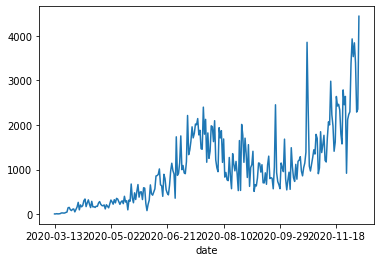

In [ ]:
df['Alabama']['no_cases'].plot();

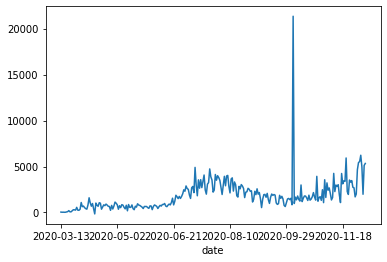

In [ ]:
df['Georgia']['no_cases'].plot();

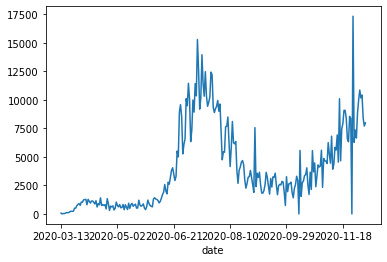

In [ ]:
df['Florida']['no_cases'].plot();

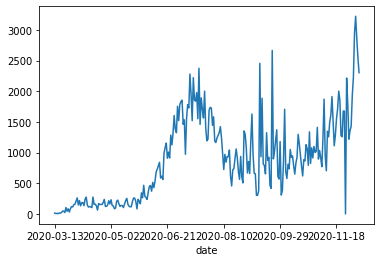

In [ ]:
df['South Carolina']['no_cases'].plot();

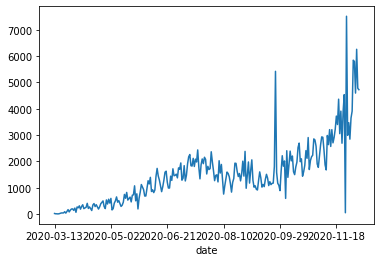

In [ ]:
df['North Carolina']['no_cases'].plot();

In [ ]:
df[(df['Alabama']['no_deaths'] < 0)]

Alabama            Florida  ... South Carolina           Various
           no_cases no_deaths no_cases  ...       no_cases no_deaths     Day
date                                    ...                                 
2020-04-18      151        -4      739  ...            160         3     109
2020-04-23      222        -4     1339  ...            156        10     114
2020-05-02      317        -1      735  ...            231        11     123
2020-09-25     2452       -15     2847  ...           1195        18     269
2020-09-28      662        -1      738  ...            568        11     272

[5 rows x 11 columns]

In [ ]:
df[(df['Georgia']['no_cases'] < 0)]

Empty DataFrame
Columns: [(Alabama, no_cases), (Alabama, no_deaths), (Florida, no_cases), (Florida, no_deaths), (Georgia, no_cases), (Georgia, no_deaths), (North Carolina, no_cases), (North Carolina, no_deaths), (South Carolina, no_cases), (South Carolina, no_deaths)]
Index: []

## Data Error
There are some errors in Georgia and North Carolina. As shown in the plots above, the number of cases in GA and NC suddenly jumped to 21349 and 5422 cases, respectively. Also we see some negative values in Georgia and Alabama which we impute them accordingly.
So this is clearly a data error, and we correct those errors by imputing.

In [ ]:
df['Georgia']['no_cases']['2020-10-05']=int((df['Georgia']['no_cases']['2020-10-04']+df['Georgia']['no_cases']['2020-10-06'])/2)
df['Georgia']['no_cases']['2020-04-12']=(df['Georgia']['no_cases']['2020-04-11']+df['Georgia']['no_cases']['2020-04-13'])/2

df['Alabama']['no_deaths']['2020-04-18']=int((df['Alabama']['no_deaths']['2020-04-17']+df['Alabama']['no_deaths']['2020-04-19'])/2)
df['Alabama']['no_deaths']['2020-04-23']=int((df['Alabama']['no_deaths']['2020-04-22']+df['Alabama']['no_deaths']['2020-04-25'])/2)
df['Alabama']['no_deaths']['2020-05-02']=int((df['Alabama']['no_deaths']['2020-05-01']+df['Alabama']['no_deaths']['2020-05-03'])/2)
df['Alabama']['no_deaths']['2020-09-25']=(df['Alabama']['no_deaths']['2020-09-24']+df['Alabama']['no_deaths']['2020-09-26'])/2
df['Alabama']['no_deaths']['2020-09-28']=int((df['Alabama']['no_deaths']['2020-09-27']+df['Alabama']['no_deaths']['2020-09-29'])/2)

df['North Carolina']['no_cases']['2020-09-25']=(df['North Carolina']['no_cases']['2020-09-24']+df['North Carolina']['no_cases']['2020-09-26'])/2

In [ ]:
df.drop(('Alabama', 'cases'), axis=1, inplace=True)
df.drop(('Alabama', 'deaths'), axis=1, inplace=True)

df.drop(('Georgia', 'cases'), axis=1, inplace=True)
df.drop(('Georgia', 'deaths'), axis=1, inplace=True)

df.drop(('Florida', 'cases'), axis=1, inplace=True)
df.drop(('Florida', 'deaths'), axis=1, inplace=True)

df.drop(('South Carolina', 'cases'), axis=1, inplace=True)
df.drop(('South Carolina', 'deaths'), axis=1, inplace=True)

df.drop(('North Carolina', 'cases'), axis=1, inplace=True)
df.drop(('North Carolina', 'deaths'), axis=1, inplace=True)

In [ ]:
df.head(1)

Alabama            Florida  ... North Carolina South Carolina          
           no_cases no_deaths no_cases  ...      no_deaths       no_cases no_deaths
date                                    ...                                        
2020-03-13        6         0       70  ...              0             13         0

[1 rows x 10 columns]

There are 10 input-signals in the data-set.

In [ ]:
df.values.shape

(271, 10)

In [ ]:
df.index = pd.to_datetime(df.index)
df['Various', 'Day'] = df.index.dayofyear

### Target Data for Prediction

We will try and predict the future Covid-cases for Georgia.

In [ ]:
target_state = 'Georgia'

We will try and predict these signals.

In [ ]:
target_names = ['no_cases', 'no_deaths']

In [ ]:
shift_steps = 20 # number of days we want to predict in the future to see the accuracy

Create a new data-frame with the time-shifted data.

In [ ]:
df_targets = df[target_state][target_names].shift(-shift_steps)

In [ ]:
df[target_state][target_names].head(shift_steps + 5)

,no_cases,no_deaths
date,,
2020-03-13,41,1
2020-03-14,24,0
2020-03-15,32,0
2020-03-16,21,0
2020-03-17,24,0
2020-03-18,51,2
2020-03-19,89,7
2020-03-20,200,4
2020-03-21,70,6


In [ ]:
df_targets.head(20)

,no_cases,no_deaths
date,,
2020-03-13,697,22
2020-03-14,523,22
2020-03-15,416,10
2020-03-16,359,11
2020-03-17,816,75
2020-03-18,1598,54
2020-03-19,1048,22
2020-03-20,681,42
2020-03-21,974,13


The time-shifted data-frame has the same length as the original data-frame, but the last observations are `NaN` (not a number) because the data has been shifted backwards so we are trying to shift data that does not exist in the original data-frame.

In [ ]:
df_targets.tail()

,no_cases,no_deaths
date,,
2020-12-04,<NA>,<NA>
2020-12-05,<NA>,<NA>
2020-12-06,<NA>,<NA>
2020-12-07,<NA>,<NA>
2020-12-08,<NA>,<NA>


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [ ]:
x_data = df.values[0:-shift_steps]

In [ ]:
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (251, 11)


These are the output-signals (or target-signals):

In [ ]:
y_data = df_targets.values[:-shift_steps]

In [ ]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (251, 2)


This is the number of observations (aka. data-points or samples) in the data-set:

In [ ]:
num_data = len(x_data)
num_data

251

The fraction of the data-set that will be used for the training-set:

In [ ]:
train_split = 0.8

Number of observations in the training-set:

In [ ]:
num_train = int(train_split * num_data)
num_train

200

Number of observations in the test-set:

In [ ]:
num_test = num_data - num_train
num_test

51

These are the input-signals for the training- and test-sets:

In [ ]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

251

The output-signals for the training- and test-sets:

In [ ]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

251

The number of input-signals:

In [ ]:
num_x_signals = x_data.shape[1]
num_x_signals

11

This is the number of output-signals:

In [ ]:
num_y_signals = y_data.shape[1]
num_y_signals

2

### Scaled Data

The data-set contains a wide range of values:

In [ ]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0
Max: 15300


The neural network works best on values roughly between 0 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [ ]:
x_scaler = MinMaxScaler()

We then detect the range of values from the training-data and scale the training-data.

In [ ]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [ ]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0


We use the same scaler-object for the input-signals in the test-set.

In [ ]:
x_test_scaled = x_scaler.transform(x_test)

The target-data comes from the same data-set as the input-signals, because it is the Covid-data for one of the States that is merely time-shifted. But the target-data could be from a different source with different value-ranges, so we create a separate scaler-object for the target-data.

In [ ]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost some thousands observations, consisting of 11 input-signals and 2 output-signals.

These are the array-shapes of the input and output data:

In [ ]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(200, 11)
(200, 2)


Instead of training the Recurrent Neural Network on the complete sequences of all observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [ ]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [ ]:
batch_size = 256

We will use a sequence-length of 50, which means that each random sequence contains observations for 50 days. One time-step corresponds to one hour, so 7 time-steps corresponds to a week.

In [ ]:
sequence_length = 50

We then create the batch-generator.

In [ ]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

We can then test the batch-generator to see if it works.

In [ ]:
x_batch, y_batch = next(generator)

This gives us a random batch of 256 sequences, each sequence having 50 observations, and each observation having 11 input-signals and 2 output-signals.

In [ ]:
print(x_batch.shape)
print(y_batch.shape)

(256, 50, 11)
(256, 50, 2)


We can plot one of the 11 input-signals as an example.

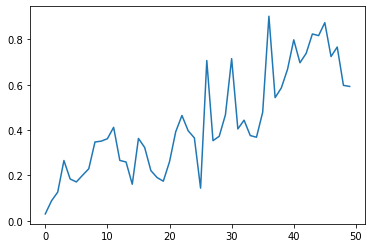

In [ ]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 11 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

We can also plot one of the output-signals that we want the model to learn how to predict given all those 11 input signals.

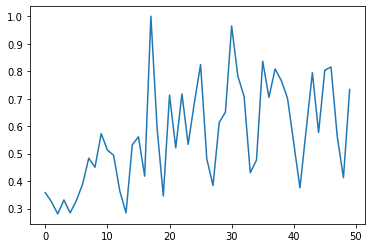

In [ ]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

### Validation Set

The neural network trains quickly so we can easily run many training epochs. But then there is a risk of overfitting the model to the training-set so it does not generalize well to unseen data. We will therefore monitor the model's performance on the test-set after each epoch and only save the model's weights if the performance is improved on the test-set.

The batch-generator randomly selects a batch of short sequences from the training-data and uses that during training. But for the validation-data we will instead run through the entire sequence from the test-set and measure the prediction accuracy on that entire sequence.

In [ ]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity.

In [ ]:
model = Sequential()

We can now add a Gated Recurrent Unit (GRU) to the network. This will have 512 outputs for each time-step in the sequence.

Note that because this is the first layer in the model, Keras needs to know the shape of its input, which is a batch of sequences of arbitrary length (indicated by `None`), where each observation has a number of input-signals (`num_x_signals`).

In [ ]:
model.add(GRU(units=512,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

The GRU outputs a batch of sequences of 512 values. We want to predict 2 output-signals, so we add a fully-connected (or dense) layer which maps 512 values down to only 2 values.

The output-signals in the data-set have been limited to be between 0 and 1 using a scaler-object. So we also limit the output of the neural network using the Sigmoid activation function, which squashes the output to be between 0 and 1.

In [ ]:
model.add(Dense(num_y_signals, activation='sigmoid'))

A problem with using the Sigmoid activation function, is that we can now only output values in the same range as the training-data.

For example, if the training-data only has Covid cases between 10 and 3000, then the scaler-object will map 10 to 0 and 3000 to 1. So if we limit the output of the neural network to be between 0 and 1 using the Sigmoid function, this can only be mapped back to Covid cases values between 10 and 3000.

We can use a linear activation function on the output instead. This allows for the output to take on arbitrary values. It might work with the standard initialization for a simple network architecture, but for more complicated network architectures e.g. with more layers, it might be necessary to initialize the weights with smaller values to avoid `NaN` values during training. You may need to experiment with this to get it working.

In [ ]:
if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

### Loss Function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 15 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [ ]:
warmup_steps = 15

In [ ]:
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

### Compile Model

This is the optimizer and the beginning learning-rate that we will use.

In [ ]:
optimizer = RMSprop(lr=1e-3)

We then compile the Keras model so it is ready for training.

In [ ]:
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

This is a very small model with only two layers. The output shape of `(None, None, 2)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 2 signals. This corresponds to the 2 target signals we want to predict.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         806400    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 807,426
Trainable params: 807,426
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [ ]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [ ]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

The callback for writing the TensorBoard log during training.

In [ ]:
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [ ]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [ ]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [ ]:
%%time
model.fit(x=generator,
          epochs=20,
          steps_per_epoch=20,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/20
20/20 [==============================] - ETA: 0s - loss: 0.0242
Epoch 00001: val_loss improved from inf to 0.25775, saving model to 23_checkpoint.keras
20/20 [==============================] - 1s 53ms/step - loss: 0.0242 - val_loss: 0.2577
Epoch 2/20
19/20 [===========================>..] - ETA: 0s - loss: 0.0202
Epoch 00002: val_loss improved from 0.25775 to 0.25172, saving model to 23_checkpoint.keras
20/20 [==============================] - 1s 28ms/step - loss: 0.0202 - val_loss: 0.2517
Epoch 3/20
19/20 [===========================>..] - ETA: 0s - loss: 0.0190
Epoch 00003: val_loss improved from 0.25172 to 0.25027, saving model to 23_checkpoint.keras
20/20 [==============================] - 1s 28ms/step - loss: 0.0189 - val_loss: 0.2503
Epoch 4/20
20/20 [==============================] - ETA: 0s - loss: 0.0181
Epoch 00004: val_loss did not improve from 0.25027
20/20 [==============================] - 1s 28ms/step - loss: 0.0181 - val_loss: 0.2508
Epoch 5/20
20/20 [=======

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [ ]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

1/1 [==============================] - 0s 1ms/step - loss: 0.2500


In [ ]:
print("loss (test-set):", result)

loss (test-set): 0.24995149672031403


In [ ]:
# Using several metric functions
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

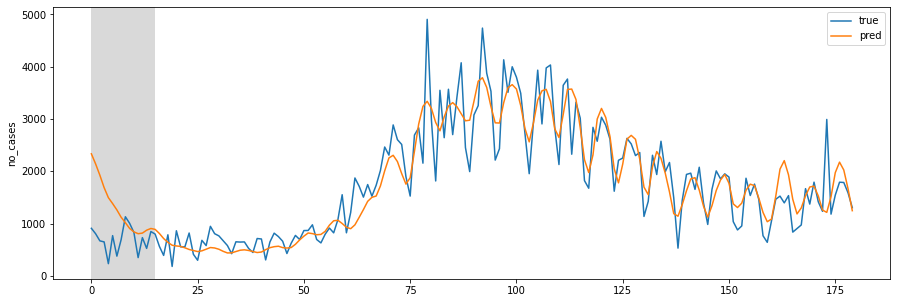

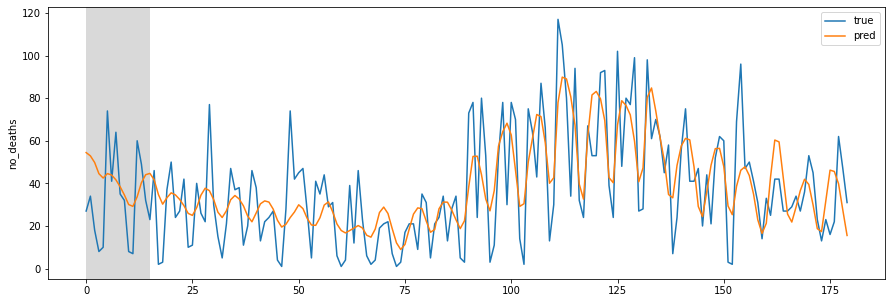

In [ ]:
plot_comparison(start_idx=20, length=200, train=True)

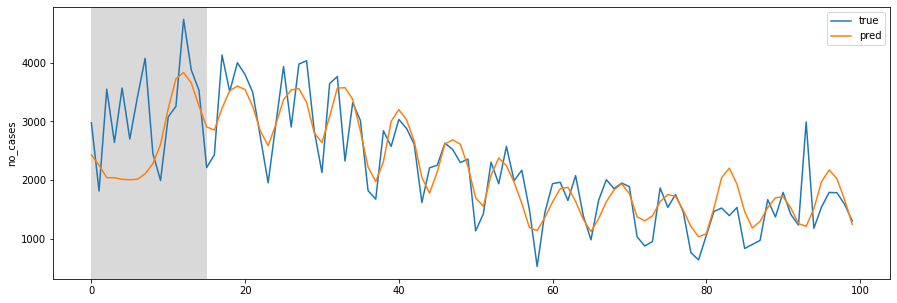

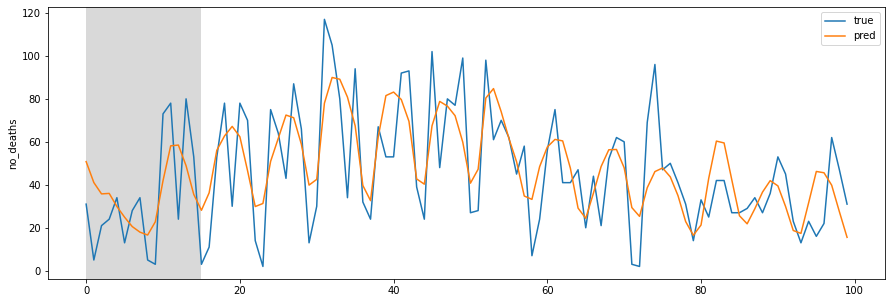

In [ ]:
plot_comparison(start_idx=100, length=100, train=True)

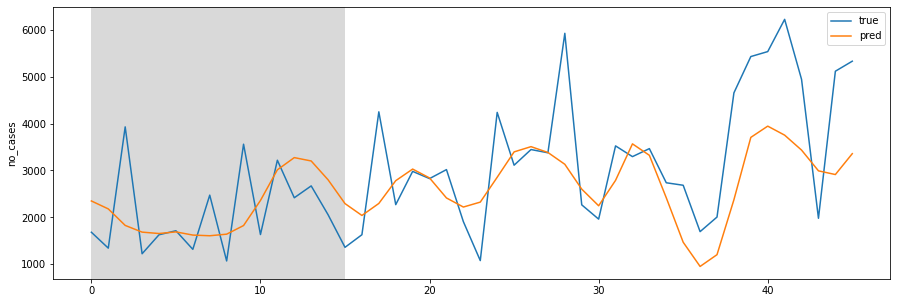

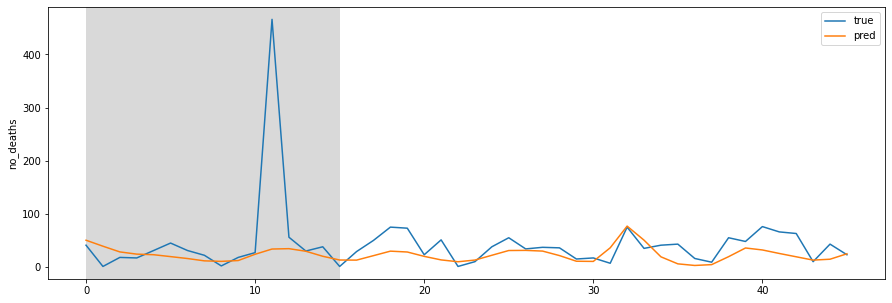

In [ ]:
plot_comparison(start_idx=5, length=50, train=False)